In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Preliminary: Updated Data Loading**

**a.**

In [27]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
data_filename = list(uploadedData)[0]

Please load the raw csv data


Saving HW3_data.csv to HW3_data.csv


In [28]:
data = pd.read_csv(data_filename)

**b.**

In [29]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, train_size=0.8, random_state=157)

In [30]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

**c.**

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Helper Functions:

def blood_type_seperation(new_data):
    group0_bool = new_data["blood_type"].isin(["O+", "O-"])
    group1_bool = new_data["blood_type"].isin(["B+", "B-", "AB+", "AB-"])
    group2_bool = new_data["blood_type"].isin(["A+", "A-"])

    new_blood_columns = [[], [], []]
    for i in range(0, len(group0_bool)):
        if np.array(group0_bool)[i]:
            new_blood_columns[0].append(1)
        else:
            new_blood_columns[0].append(0)

        if np.array(group1_bool)[i]:
            new_blood_columns[1].append(1)
        else:
            new_blood_columns[1].append(0)

        if np.array(group2_bool)[i]:
            new_blood_columns[2].append(1)
        else:
            new_blood_columns[2].append(0)

    new_data = new_data.drop('blood_type', inplace=False, axis=1)
    new_data["blood_type_group_zero"] = new_blood_columns[0]
    new_data["blood_type_group_one"] = new_blood_columns[1]
    new_data["blood_type_group_two"] = new_blood_columns[2]
    return new_data


def symptoms_correction(new_data):
    str_list = [string for string in new_data["symptoms"].unique() if not pd.isnull(string)]
    symptoms_list = []
    symptoms_columns = []

    for string in str_list:
        current_symptoms = string.split(';')
        for symptom in current_symptoms:
            if (not (symptom in symptoms_list)):
                symptoms_list.append(symptom)
                symptoms_columns.append([])

    symptoms_array = np.array(new_data["symptoms"])
    for i in range(new_data.shape[0]):
        j = 0
        for symptom in symptoms_list:
            symptom_exists = 0
            if not pd.isnull(symptoms_array[i]) and symptom in symptoms_array[i]:
                symptom_exists = 1
            symptoms_columns[j].append(symptom_exists)
            j += 1

    new_data = new_data.drop('symptoms', inplace=False, axis=1)
    j = 0
    for symptom in symptoms_list:
        new_data[symptom] = symptoms_columns[j]
        j += 1

    return new_data


def columns_correction_to_ordinal(new_data):
    male_on_index = np.array(new_data["sex"].isin(["M"]))
    location_list = np.array(new_data["current_location"])
    date_list = np.array(new_data["pcr_date"])

    sex_column = []
    location_x_column = []
    location_y_column = []
    day_list = []
    month_list = []
    year_list = []

    for i in range(new_data.shape[0]):
        binary_sex = 0
        if male_on_index[i]:
            binary_sex = 1
        sex_column.append(binary_sex)

        current_location = location_list[i].strip("(')").replace("'", "").replace(" ", "").split(',')
        location_x_column.append(float(current_location[0]))
        location_y_column.append(float(current_location[1]))

        current_date = date_list[i].split('-')
        year_list.append(int(current_date[0]))
        month_list.append(int(current_date[1]))
        day_list.append(int(current_date[2]))

    new_data = new_data.drop('sex', inplace=False, axis=1).drop('current_location', inplace=False, axis=1).drop(
        'pcr_date', inplace=False, axis=1)
    new_data["sex"] = sex_column
    new_data["x_location"] = location_x_column
    new_data["y_location"] = location_y_column
    new_data["pcr_day"] = day_list
    new_data["pcr_month"] = month_list
    new_data["pcr_year"] = year_list

    return new_data


def prepare_data(training_data, new_data):
    new_data_copy = new_data.copy()
    training_data_copy = training_data.copy()

    new_data_copy = blood_type_seperation(new_data_copy)
    new_data_copy = symptoms_correction(new_data_copy)
    new_data_copy = columns_correction_to_ordinal(new_data_copy)
    training_data_copy = blood_type_seperation(training_data_copy)
    training_data_copy = symptoms_correction(training_data_copy)
    training_data_copy = columns_correction_to_ordinal(training_data_copy)

    new_data_copy.reset_index()

    minmax_features_names = ["patient_id", "PCR_01", "PCR_02", "PCR_03", "PCR_04", "PCR_05", "PCR_09", "pcr_day",
                             "pcr_month", "pcr_year"]
    scalar_features_names = ["age", "weight", "num_of_siblings", "happiness_score", "household_income",
                             "conversations_per_day", "sugar_levels", "sport_activity", "PCR_06", "PCR_07", "PCR_08",
                             "PCR_09", "PCR_10", "x_location", "y_location"]
    data_normalized = pd.DataFrame(new_data_copy,
                                   columns=["cough", "fever", "shortness_of_breath", "low_appetite", "sore_throat",
                                            "sex", "blood_type_group_zero", "blood_type_group_one",
                                            "blood_type_group_two", "contamination_level"])

    minmax = MinMaxScaler((-1, 1))

    for name in minmax_features_names:
        minmax.fit(pd.DataFrame(training_data_copy, columns=[name]))
        data_normalized[name] = minmax.transform(pd.DataFrame(new_data_copy, columns=[name]))

    scalar = StandardScaler()

    for name in scalar_features_names:
        scalar.fit(pd.DataFrame(training_data_copy, columns=[name]))
        data_normalized[name] = scalar.transform(pd.DataFrame(new_data_copy, columns=[name]))

    return data_normalized

In [32]:
train_normalized = prepare_data(train, train)
test_normalized = prepare_data(train, test)

# **Section 1: Linear regression implementation**

For this section only, split your training set into a (new) training subset (80%)
and a validation subset (20%).

In [33]:
train_part1, validation_part1 = train_test_split(train_normalized, train_size=0.8, random_state=157)

Copy the given LinearRegressor module into your notebook / project.

In [34]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        m = y.shape[0]
        loss = (np.linalg.norm( X.dot(w) + b - y ) ** 2) / m

        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        m = y.shape[0]
        g_w = (2 / m) * (X.transpose()).dot( X.dot(w) + b - y )
        g_b = (2 / m) * np.sum( X.dot(w) + b - y )

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = LinearRegressor.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = X.dot(self.w) + self.b

        return y_pred

**Task:** Copy the functions from the given verify_gradients.py into your notebook / project.

In [35]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


**Question 2**

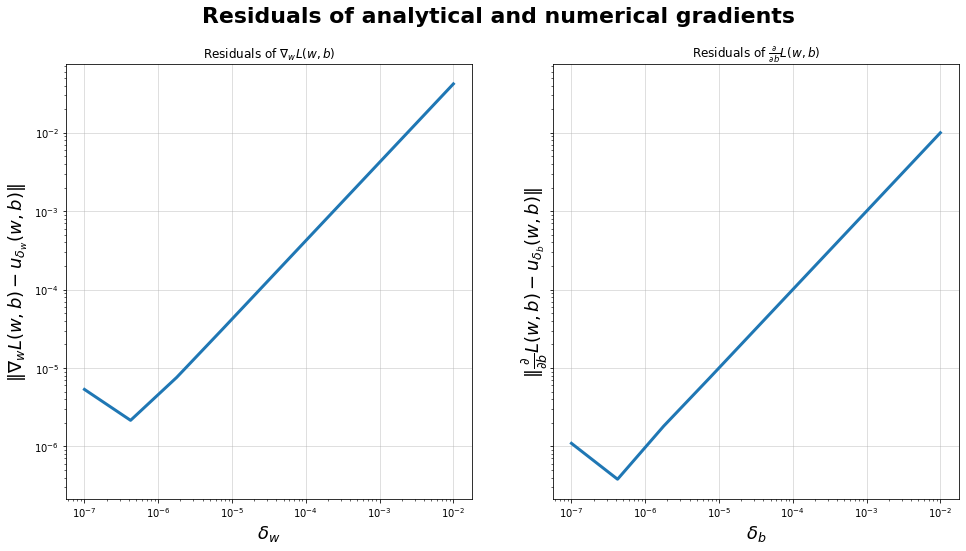

In [36]:
X_train = train_part1.drop('contamination_level', inplace=False, axis=1).values
y_train = np.array(train_part1["contamination_level"])

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

**Task:** Copy the function given in test_lr.py into your notebook / project.

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

**Question 3**

lr size = 1e-09, Best train loss = 414.2861867153678, Best validation loss = 322.60504854919895
lr size = 1e-08, Best train loss = 414.2523371452997, Best validation loss = 322.576744550384
lr size = 1e-07, Best train loss = 413.9140511886494, Best validation loss = 322.2938894803194
lr size = 1e-06, Best train loss = 410.552078041797, Best validation loss = 319.4837514440019
lr size = 1e-05, Best train loss = 378.9357274079832, Best validation loss = 293.14695543205715
lr size = 0.0001, Best train loss = 199.36353691976169, Best validation loss = 149.01694658837792
lr size = 0.001, Best train loss = 103.71517687859792, Best validation loss = 94.34092381125811
lr size = 0.01, Best train loss = 98.43972841159415, Best validation loss = 92.79197274832079
lr size = 0.1, Best train loss = 100.47534689304037, Best validation loss = 90.35860789849872


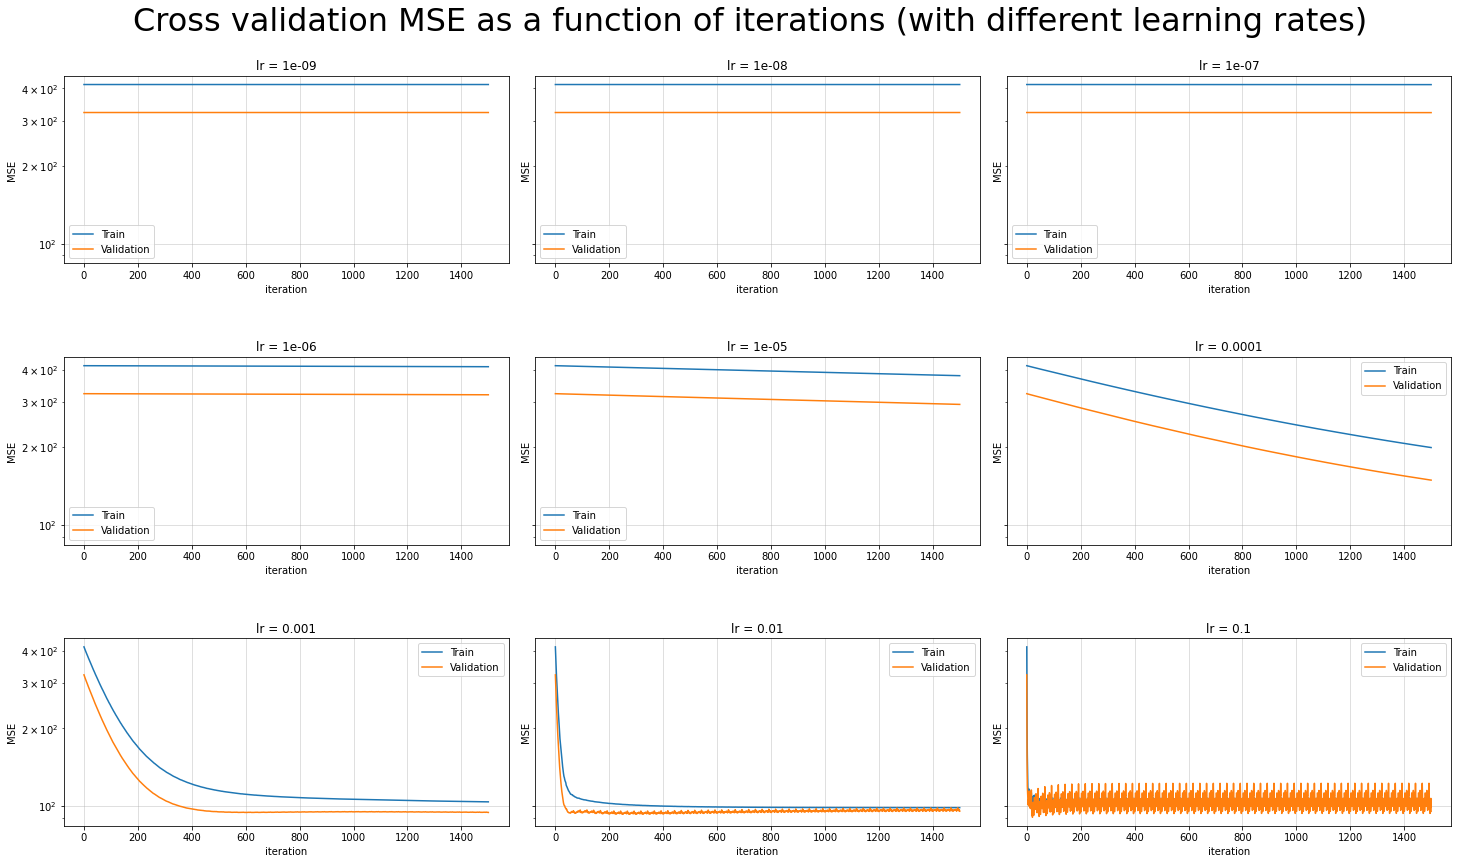

In [38]:
X_train = train_part1.drop('contamination_level', inplace=False, axis=1).values
y_train = np.array(train_part1["contamination_level"])
X_val = validation_part1.drop('contamination_level', inplace=False, axis=1).values
y_val = np.array(validation_part1["contamination_level"])


test_lr(X_train, y_train, X_val, y_val, "Cross validation MSE as a function of iterations (with different learning rates)")

# **Section 2: Evaluation and Baseline**

# Simplest baseline

**Question 4**

In [39]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

X_all_train = train_normalized.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_normalized["contamination_level"])

dummy = DummyRegressor(strategy = "mean")
cv_results = cross_validate(dummy, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')

In [40]:
print("The train score:", abs( cv_results['train_score'].mean() ) )
print("The test score:", abs(cv_results['test_score'].mean() ) )
valid_score_dummy = abs(cv_results['test_score'].mean() )

The train score: 108.84191681912667
The test score: 108.88985300964778


**Task:** Retrain the dummy regressor on the entire training set (= all its samples) and save it for
future use.

In [41]:
X_all_train = train_normalized.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_normalized["contamination_level"])
best_dummy = DummyRegressor(strategy = "mean")
best_dummy.fit(X_all_train, y_all_train)

DummyRegressor()

# Basic hyperparameter tuning

**Question 5**

In [42]:
lr_list = np.logspace(-3.5, -1.5, 10)
train_score_list = []
validation_score_list = []

X_all_train = train_normalized.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_normalized["contamination_level"])

for learning_rate in lr_list:
  LinearReg = LinearRegressor(learning_rate)
  cv_results = cross_validate(LinearReg, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
  train_score_list.append( abs( cv_results['train_score'].mean() ) )
  validation_score_list.append( abs( cv_results['test_score'].mean() ) )

[]

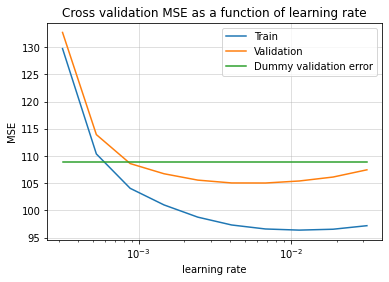

In [43]:
plt.semilogx(lr_list, train_score_list, label="Train")
plt.semilogx(lr_list, validation_score_list, label="Validation")
plt.semilogx( [ lr_list[0], lr_list[-1] ], [valid_score_dummy, valid_score_dummy], label="Dummy validation error" )
plt.grid(alpha=0.5)
plt.legend()
plt.title('Cross validation MSE as a function of learning rate')
plt.xlabel('learning rate')
plt.ylabel('MSE')
plt.plot()

In [44]:
best_lr_index = validation_score_list.index(min(validation_score_list))
best_lr = lr_list[best_lr_index]
print('Best learning rate: ', best_lr)
print('Training cross validation MSE:', train_score_list[best_lr_index])
print('Validation cross validation MSE:', validation_score_list[best_lr_index])

Best learning rate:  0.006812920690579608
Training cross validation MSE: 96.595069058028
Validation cross validation MSE: 105.04300657126058


**Task:** Using the best performing hyperparameter, retrain the regressor on the entire training
set (= with all its samples) and save it for future use.

In [45]:
X_all_train = train_normalized.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_normalized["contamination_level"])

best_LinearReg = LinearRegressor(best_lr)
best_LinearReg.fit(X_all_train, y_all_train)

LinearRegressor(lr=0.006812920690579608)

# **Section 3: Linear regression with Lasso**

**Question 7**

In [46]:
from sklearn.linear_model import Lasso
lambdas = np.logspace(-4, 1, 10)

train_score_list_lasso = []
validation_score_list_lasso = []

X_all_train = train_normalized.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_normalized["contamination_level"])

for curr_lambda in lambdas:
  Lasso_model = Lasso(alpha = curr_lambda, fit_intercept = True)
  cv_results = cross_validate(Lasso_model, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
  train_score_list_lasso.append( abs( cv_results['train_score'].mean() ) )
  validation_score_list_lasso.append( abs( cv_results['test_score'].mean() ) )

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.874e+02, tolerance: 8.572e+00
  model = cd_fast.enet_coordinate_descent(


[]

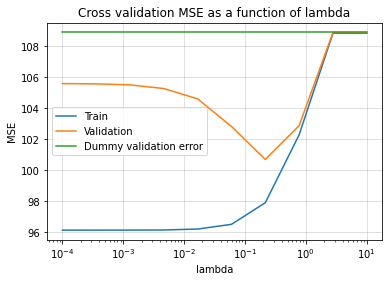

In [47]:
plt.semilogx(lambdas, train_score_list_lasso, label="Train")
plt.semilogx(lambdas, validation_score_list_lasso, label="Validation")
plt.semilogx( [ lambdas[0], lambdas[-1] ], [valid_score_dummy, valid_score_dummy], label="Dummy validation error" )
plt.grid(alpha=0.5)
plt.legend()
plt.title('Cross validation MSE as a function of lambda')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.plot()

In [48]:
best_lambda_index = validation_score_list_lasso.index(min(validation_score_list_lasso))
best_lambda = lambdas[best_lambda_index]
print('Best lambda:', best_lambda)
print('Training cross validation MSE:', train_score_list_lasso[best_lambda_index])
print('Validation cross validation MSE:', validation_score_list_lasso[best_lambda_index])

Best lambda: 0.21544346900318845
Training cross validation MSE: 97.90402628676307
Validation cross validation MSE: 100.693385647475


**Task:** Using the best performing hyperparameter, retrain the regressor on the entire
training set (= with all its samples) and save it for future use.

In [49]:
X_all_train = train_normalized.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_normalized["contamination_level"])

best_LassoReg = Lasso(alpha = best_lambda, fit_intercept = True)
best_LassoReg.fit(X_all_train, y_all_train)

Lasso(alpha=0.21544346900318845)

**Question 9**

In [50]:
best_LassoReg.coef_

array([ 0.        ,  0.        ,  0.        ,  0.35374363,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -2.57914904, -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.78272913,  0.        , -0.        ,
       -0.        , -0.40412443,  0.        ,  0.21760012, -0.        ,
        2.01547622, -0.21881921,  0.        , -0.02067639, -0.        ,
       -0.35343748, -0.        ,  0.33061432])

In [51]:
coefficients = best_LassoReg.coef_
abs_coeff = [abs(ele) for ele in coefficients]
res = np.sort(abs_coeff)[::-1]

indexs = []
best_features_names = []
best_features_coef = []
for i in range(5):
  curr_index = abs_coeff.index(res[i])
  best_features_names.append(train_normalized.columns[curr_index])
  indexs.append(curr_index)
  best_features_coef.append(res[i])

In [52]:
print("The features with the largest coefficient in descending order:")
for i in range(0,5):
  print("Place:", i + 1 , "; Index: ",indexs[i], "; feature name:", best_features_names[i], "; Coefficient absolute value:", best_features_coef[i])

The features with the largest coefficient in descending order:
Place: 1 ; Index:  10 ; feature name: patient_id ; Coefficient absolute value: 2.5791490378192856
Place: 2 ; Index:  25 ; feature name: conversations_per_day ; Coefficient absolute value: 2.0154762153859522
Place: 3 ; Index:  17 ; feature name: pcr_day ; Coefficient absolute value: 0.7827291266442216
Place: 4 ; Index:  21 ; feature name: weight ; Coefficient absolute value: 0.4041244254008717
Place: 5 ; Index:  3 ; feature name: low_appetite ; Coefficient absolute value: 0.35374363116504925


[]

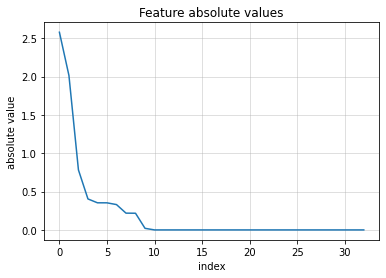

In [53]:
plt.plot(range(len(res)),res)
plt.grid(alpha=0.5)
plt.title('Feature absolute values')
plt.xlabel('index')
plt.ylabel('absolute value')
plt.plot()

# **Section 4: Polynomial fitting (visualization)**

**Task:** Create a subset of the training set with these 2 features and contamination_level.

In [54]:
train_subset = pd.DataFrame(train_normalized[["PCR_01", "PCR_05", "contamination_level"]])

**Task:** Visualize the data using plot3d, i.e., plot contamination_level as a function of the PCR_01 and PCR_05 features.

In [55]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

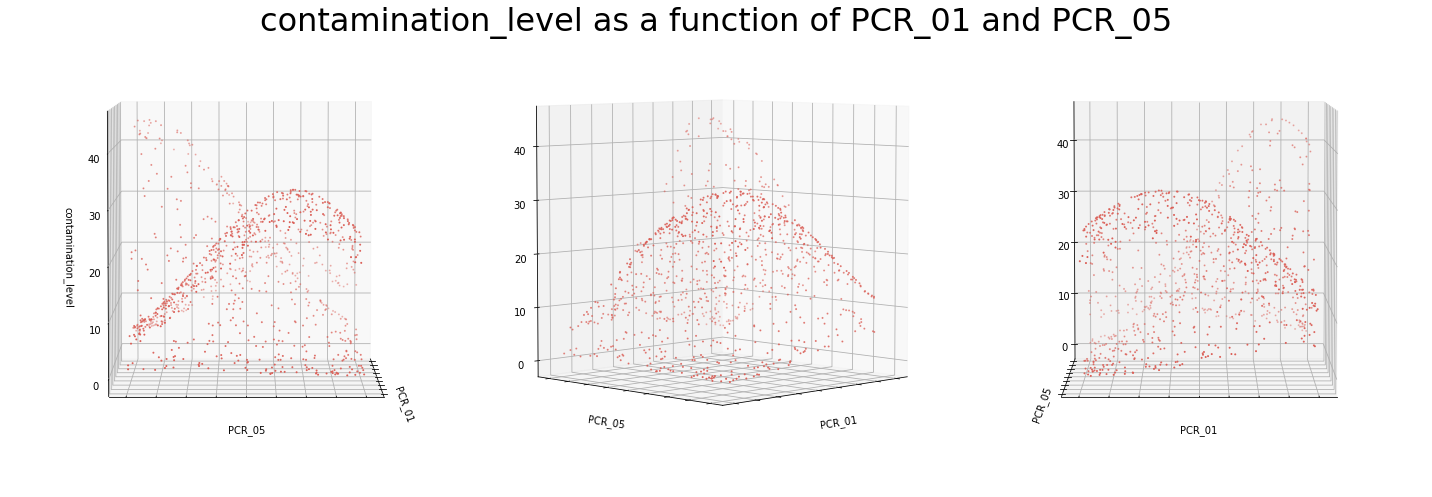

In [56]:
plot3d(train_subset, "PCR_01", "PCR_05", "contamination_level", "contamination_level as a function of PCR_01 and PCR_05")

**Question 14**

In [57]:
from sklearn.linear_model import Lasso
lambdas = np.logspace(-2, 1, 10)

train_score_list_lasso = []
validation_score_list_lasso = []

X_all_train = train_subset.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_subset["contamination_level"])
dummy = DummyRegressor(strategy = "mean")

cv_results = cross_validate(dummy, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
valid_score_dummy_subset = abs( cv_results['train_score'].mean() )

for curr_lambda in lambdas:
  Lasso_model = Lasso(alpha = curr_lambda, fit_intercept = True)
  cv_results = cross_validate(Lasso_model, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
  train_score_list_lasso.append( abs( cv_results['train_score'].mean() ) )
  validation_score_list_lasso.append( abs( cv_results['test_score'].mean() ) )

[]

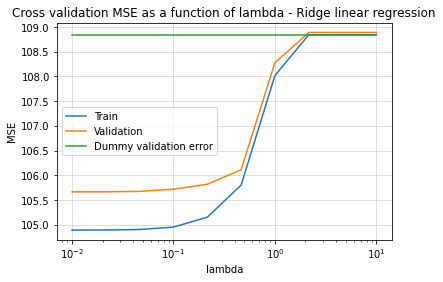

In [58]:
plt.semilogx(lambdas, train_score_list_lasso, label="Train")
plt.semilogx(lambdas, validation_score_list_lasso, label="Validation")
plt.semilogx( [ lambdas[0], lambdas[-1] ], [valid_score_dummy_subset, valid_score_dummy_subset], label="Dummy validation error" )
plt.grid(alpha=0.5)
plt.legend()
plt.title('Cross validation MSE as a function of lambda - Ridge linear regression')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.plot()

In [59]:
best_lambda_index_subset = validation_score_list_lasso.index(min(validation_score_list_lasso))
best_lambda_subset = lambdas[best_lambda_index_subset]
print('Best lambda:', best_lambda_subset)
print('Training cross validation MSE:', train_score_list_lasso[best_lambda_index_subset])
print('Validation cross validation MSE:', validation_score_list_lasso[best_lambda_index_subset])

Best lambda: 0.01
Training cross validation MSE: 104.88996735820331
Validation cross validation MSE: 105.66414899462445


**Task:** Using the best performing hyperparameter, retrain the Lasso regressor on the entire training set (= with all its samples).

In [60]:
X_all_train_subset = pd.DataFrame(train_normalized[["PCR_01", "PCR_05"]])
y_all_train_subset = np.array(train_subset["contamination_level"])

best_LassoReg_subset = Lasso(alpha = best_lambda_subset, fit_intercept = True)
best_LassoReg_subset.fit(X_all_train_subset, y_all_train_subset)

Lasso(alpha=0.01)

**Question 15:**

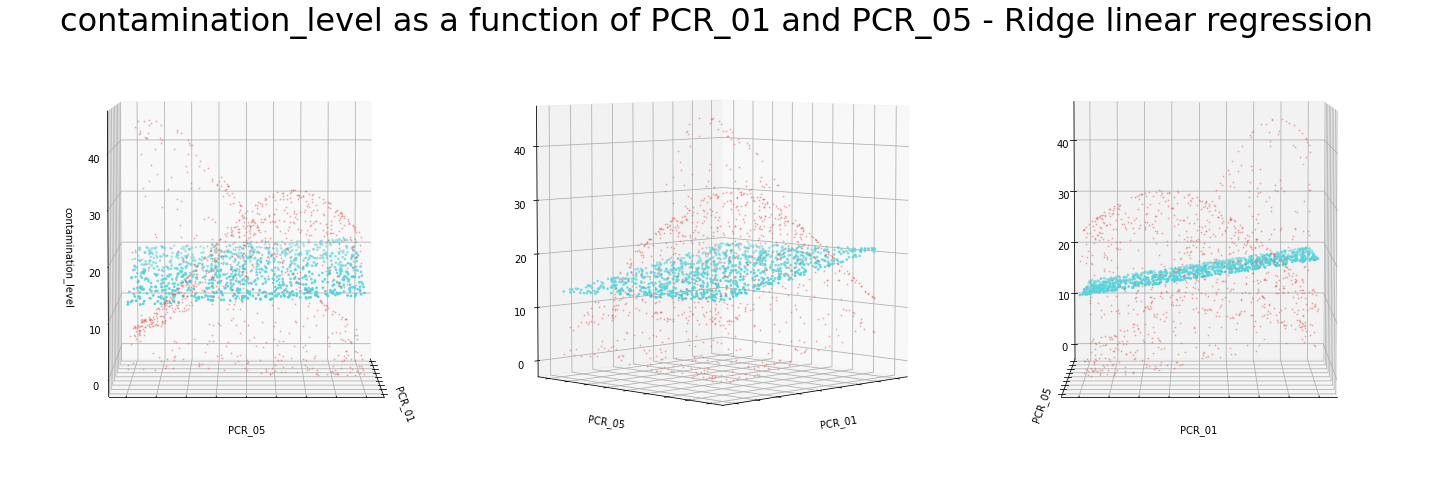

In [61]:
predictions_subset = best_LassoReg_subset.predict(X_all_train_subset)
plot3d(train_subset, "PCR_01", "PCR_05", "contamination_level", "contamination_level as a function of PCR_01 and PCR_05 - Ridge linear regression", predictions =  predictions_subset)

**Task:** Create a single model that: (1) transforms the original features into 2nd-degree polynomial features, (2) normalizes the transformed features, and then (3) trains the linear Lasso regressor on these normalized polynomial features.

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
poly_reg = Pipeline([('feature_mapping', PolynomialFeatures() ),
                      ('normalization', StandardScaler()),
                      ('Lasso', Lasso(alpha=best_lambda_subset, fit_intercept=True) ) ])

**Question 17:**

In [63]:
from sklearn.linear_model import Lasso
lambdas_pipeline = np.logspace(-3, 2, 20)

train_score_list_pipeline = []
validation_score_list_pipeline = []

X_all_train = train_subset.drop('contamination_level', inplace=False, axis=1).values
y_all_train = np.array(train_subset["contamination_level"])
dummy = DummyRegressor(strategy = "mean")

cv_results = cross_validate(dummy, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
valid_score_dummy_subset = abs( cv_results['train_score'].mean() )

for curr_lambda in lambdas_pipeline:
  Pipeline_model = Pipeline([('feature_mapping', PolynomialFeatures() ),
                      ('normalization', StandardScaler()),
                      ('Lasso', Lasso(alpha=curr_lambda, fit_intercept=True) ) ])
  cv_results = cross_validate(Pipeline_model, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
  train_score_list_pipeline.append( abs( cv_results['train_score'].mean() ) )
  validation_score_list_pipeline.append( abs( cv_results['test_score'].mean() ) )

[]

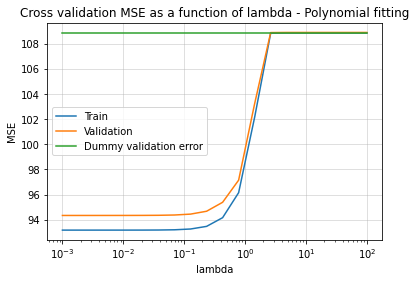

In [64]:
plt.semilogx(lambdas_pipeline, train_score_list_pipeline, label="Train")
plt.semilogx(lambdas_pipeline, validation_score_list_pipeline, label="Validation")
plt.semilogx( [ lambdas_pipeline[0], lambdas_pipeline[-1] ], [valid_score_dummy_subset, valid_score_dummy_subset], label="Dummy validation error" )
plt.grid(alpha=0.5)
plt.legend()
plt.title('Cross validation MSE as a function of lambda - Polynomial fitting')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.plot()

In [65]:
best_lambda_index_pipeline = validation_score_list_pipeline.index(min(validation_score_list_pipeline))
best_lambda_pipeline = lambdas_pipeline[best_lambda_index_pipeline]
print('Best lambda:', best_lambda_pipeline)
print('Training cross validation MSE:', train_score_list_pipeline[best_lambda_index_pipeline])
print('Validation cross validation MSE:', validation_score_list_pipeline[best_lambda_index_pipeline])

Best lambda: 0.001
Training cross validation MSE: 93.18116098898739
Validation cross validation MSE: 94.34603849476173


**Task:** Using the best performing hyperparameter, retrain the Lasso regressor on the entire
training set (= with all its samples).

In [66]:
X_all_train_subset = pd.DataFrame(train_normalized[["PCR_01", "PCR_05"]])
y_all_train_subset = np.array(train_subset["contamination_level"])

best_PolyFit_subset = Pipeline([('feature_mapping', PolynomialFeatures() ),
                      ('normalization', StandardScaler()),
                      ('Lasso', Lasso(alpha=best_lambda_pipeline, fit_intercept=True) ) ])
best_PolyFit_subset.fit(X_all_train_subset, y_all_train_subset)

Pipeline(steps=[('feature_mapping', PolynomialFeatures()),
                ('normalization', StandardScaler()),
                ('Lasso', Lasso(alpha=0.001))])

**Question 18:**

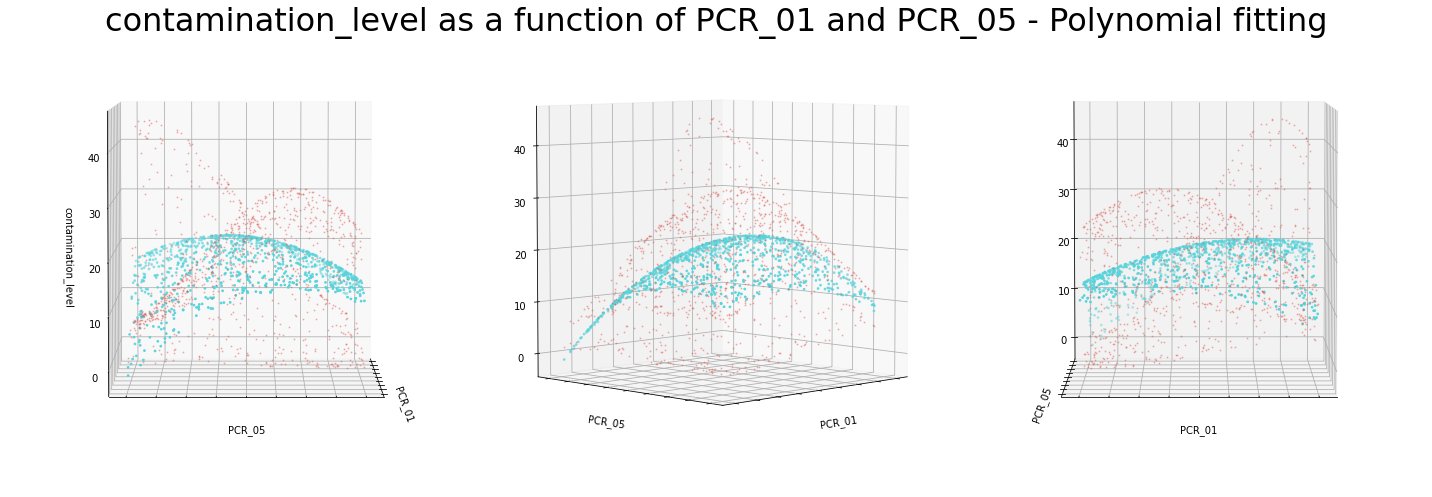

In [67]:
predictions_subset = best_PolyFit_subset.predict(X_all_train_subset)
plot3d(train_subset, "PCR_01", "PCR_05", "contamination_level", "contamination_level as a function of PCR_01 and PCR_05 - Polynomial fitting", predictions =  predictions_subset)

# **Section 5: RandomForest fitting of the CovidScore**

**Task:** Create copies of your train and test sets (with all the features).

In [68]:
X_all_train_cpy = train_normalized.drop('contamination_level', inplace=False, axis=1).copy()
y_all_train_cpy = np.array(train_subset["contamination_level"]).copy()


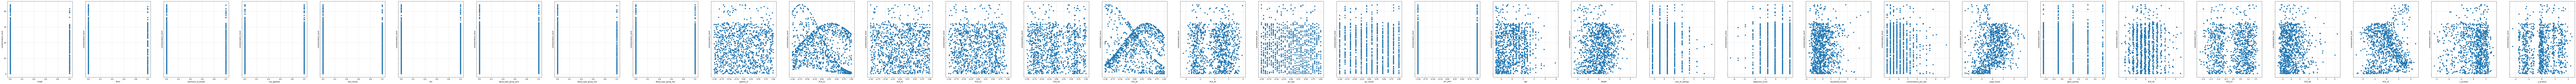

In [69]:
length = len(X_all_train_cpy.columns)
fig, axs = plt.subplots( 1, length, sharey=True, figsize=(8 * length, 8))
i = 0

for column_name in X_all_train_cpy.columns:
  axs[i].scatter( np.array(X_all_train_cpy[column_name]), y_all_train_cpy)
  axs[i].grid(alpha=0.5)
  axs[i].set_xlabel(column_name)
  axs[i].set_ylabel('contamination_level')
  axs[i].plot()
  i += 1

In [70]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestRegressor

Find optimal gamma

In [71]:
gamma_list = np.logspace(-6, 3, 10)
train_score_list_gamma = []
validation_score_list_gamma = []

X_all_train = pd.DataFrame(train_normalized[["PCR_01", "PCR_05"]])
y_all_train = np.array(train_normalized["contamination_level"])

for curr_gamma in gamma_list:
  Pipeline_model = Pipeline([('feature_mapping', RBFSampler(gamma = curr_gamma, random_state = 157)),
                      ('RFR', RandomForestRegressor() ) ])
  cv_results = cross_validate(Pipeline_model, X_all_train, y_all_train, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
  train_score_list_gamma.append( abs( cv_results['train_score'].mean() ) )
  validation_score_list_gamma.append( abs( cv_results['test_score'].mean() ) )
  print("done")

best_gamma_index = validation_score_list_gamma.index(min(validation_score_list_gamma))
best_gamma = gamma_list[best_gamma_index]

done
done
done
done
done
done
done
done
done
done


[]

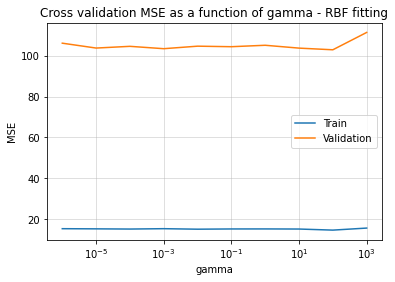

In [72]:
plt.semilogx(gamma_list, train_score_list_gamma, label="Train")
plt.semilogx(gamma_list, validation_score_list_gamma, label="Validation")
plt.grid(alpha=0.5)
plt.legend()
plt.title('Cross validation MSE as a function of gamma - RBF fitting')
plt.xlabel('gamma')
plt.ylabel('MSE')
plt.plot()

In [73]:
from sklearn.compose import ColumnTransformer

Find best projections:

**current problem** - can't check features individually (algorithms problem), needs to check all the features togther. Too many options (3^5).



In [74]:
Columns_per_transformer_dict = {"None":[], "RBF":[], "Poly_5":[]}
columns_scores = [["None", "RBF", "Poly_5"]]
names_transformers = [("RBF", RBFSampler(gamma = best_gamma, random_state = 157)), ("Poly_5", PolynomialFeatures(degree = 5))]
ColumnTransformer_list = []

non_binary_columns = ['patient_id', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_09', 'pcr_day',
       'pcr_month', 'age', 'weight', 'num_of_siblings', 'happiness_score', 'household_income',
       'conversations_per_day', 'sugar_levels', 'sport_activity', 'PCR_06', 'PCR_07', 'PCR_08',
       'PCR_10', 'x_location', 'y_location']

index = 0
no_mapping_score = cross_validate(RandomForestRegressor(), X_all_train_cpy, y_all_train_cpy, cv = 5, scoring='neg_mean_squared_error')['test_score'].mean()
for column in non_binary_columns:
  current_score_list = []
  best_name_transformer = ('None', None)
  best_score = no_mapping_score
  current_score_list.append(best_score)
  for name_transformer in names_transformers:
    name, transformer = name_transformer
    Pipeline_model = Pipeline([( 'feature_mapping', ColumnTransformer( [(name, transformer, [column])], remainder='passthrough' )),
                      ('RFR', RandomForestRegressor()  ) ] )
    cv_results = cross_validate(Pipeline_model, X_all_train_cpy, y_all_train_cpy, cv = 5, scoring='neg_mean_squared_error')
    current_score = cv_results['test_score'].mean()
    current_score_list.append(current_score)
    if current_score < best_score:
      best_score = current_score
      best_name_transformer = name_transformer

  name, transformer = best_name_transformer  
  Columns_per_transformer_dict[name].append(column)
  columns_scores.append(current_score_list)
  
  index += 1
  print(index, column)

for name_transformer in names_transformers:
  name, transformer = name_transformer
  ColumnTransformer_list.append( (name, transformer, Columns_per_transformer_dict[name]) )

1 patient_id
2 PCR_01
3 PCR_02
4 PCR_03
5 PCR_04
6 PCR_05
7 PCR_09
8 pcr_day
9 pcr_month
10 age
11 weight
12 num_of_siblings
13 happiness_score
14 household_income
15 conversations_per_day
16 sugar_levels
17 sport_activity
18 PCR_06
19 PCR_07
20 PCR_08
21 PCR_10
22 x_location
23 y_location


In [76]:
Columns_per_transformer_dict_improved = {"None":[], "RBF":[], "Poly_5":[]}
diff_list_poly = []
diff_list_rbf = []
for column_index, col_list in enumerate(columns_scores):
  if column_index == 0:
    continue
  max_index = col_list.index(max(col_list))
  if max_index == 1:
    diff_rbf = col_list[max_index] - col_list[0]
    diff_list_rbf.append( (non_binary_columns[column_index - 1], diff_rbf) )
  if max_index == 2:
    diff_poly = col_list[max_index] - col_list[0]
    diff_list_poly.append( (non_binary_columns[column_index - 1], diff_poly) )
  Columns_per_transformer_dict_improved[columns_scores[0][max_index]].append(non_binary_columns[column_index - 1])

In [77]:
sorted_by_second_poly = sorted(diff_list_poly, key=lambda tup: tup[1], reverse=True)
sorted_by_second_rbf = sorted(diff_list_rbf, key=lambda tup: tup[1], reverse=True)

In [100]:
print("Poly:", sorted_by_second_poly)
print("RBF:", sorted_by_second_rbf)

Poly: [('weight', 0.3777876149345616), ('PCR_02', 0.35276626707913294), ('PCR_07', 0.3114055735065402), ('pcr_month', 0.2061807854129336), ('happiness_score', 0.20005269592058772), ('PCR_08', 0.16466916274749988), ('PCR_04', 0.15849855989135353), ('sport_activity', 0.12041500935417337), ('PCR_03', 0.09687381787163885), ('PCR_09', 0.021751031864906345), ('sugar_levels', 0.01793750160957197), ('PCR_01', 0.009672951165809796), ('patient_id', 0.004295202485416372), ('PCR_06', 0.0013768737943982146)]
RBF: [('num_of_siblings', 0.316515657521554)]


In [79]:
Columns_per_transformer_dict_improved

{'None': ['PCR_05',
  'pcr_day',
  'age',
  'household_income',
  'conversations_per_day',
  'PCR_10',
  'x_location',
  'y_location'],
 'RBF': ['num_of_siblings'],
 'Poly_5': ['patient_id',
  'PCR_01',
  'PCR_02',
  'PCR_03',
  'PCR_04',
  'PCR_09',
  'pcr_month',
  'weight',
  'happiness_score',
  'sugar_levels',
  'sport_activity',
  'PCR_06',
  'PCR_07',
  'PCR_08']}

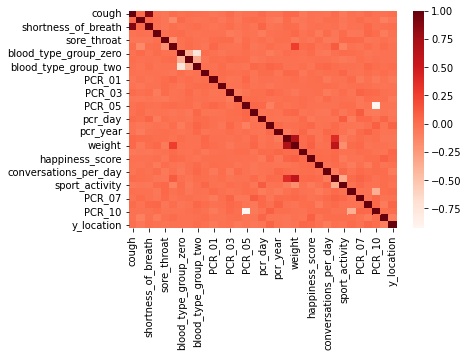

In [80]:
sns.heatmap(X_all_train_cpy.corr(), cmap="Reds", fmt=".1f")
plt.show()

In [97]:
poly_name_list = []
rbf_name_list = []
for i in range(2):
  poly_name_list.append(sorted_by_second_poly[i][0])

for i in range(1):
  rbf_name_list.append(sorted_by_second_rbf[i][0])

ColumnTransformer_list_improved = [("RBF", RBFSampler(gamma = best_gamma, random_state = 157), rbf_name_list),
                                    ("Poly_5", PolynomialFeatures(degree = 5), poly_name_list)]

In [98]:
Pipeline_model = Pipeline([( 'feature_mapping', ColumnTransformer( ColumnTransformer_list_improved, remainder='passthrough' )),
                      ('RFR', RandomForestRegressor()  ) ] )
cv_results = cross_validate(Pipeline_model, X_all_train_cpy, y_all_train_cpy, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
print("New obtained train score:", cv_results['train_score'].mean())
print("New obtained test score:", cv_results['test_score'].mean())

New obtained train score: -0.40294814266933693
New obtained test score: -2.7983437000629556


**Question 20:**

In [99]:
print("Polynomial mapping:\n", poly_name_list,"\n")
print("RBF mapping:\n", rbf_name_list)

Polynomial mapping:
 ['weight', 'PCR_02'] 

RBF mapping:
 ['num_of_siblings']


**Question 23:**

In [101]:
from sklearn.model_selection import GridSearchCV

In [102]:
parameters = {'RFR__n_estimators': [20,40,80,150,300,600], 'RFR__min_samples_leaf': [1,2,3,5,10,15,20]} ## practical focused range
grid_search = GridSearchCV(Pipeline_model, parameters, cv = 5, return_train_score=True)
grid_search.fit(X_all_train_cpy, y_all_train_cpy)
grid_search_results = pd.DataFrame(grid_search.cv_results_)

In [103]:
print("best parameters score:", grid_search.best_score_)
print("Best parameters: ", grid_search.best_params_)

best parameters score: 0.9755915231349173
Best parameters:  {'RFR__min_samples_leaf': 3, 'RFR__n_estimators': 150}


In [104]:
print( "Mean train score: ", max(grid_search_results["mean_train_score"]) )

Mean train score:  0.9965257479452081


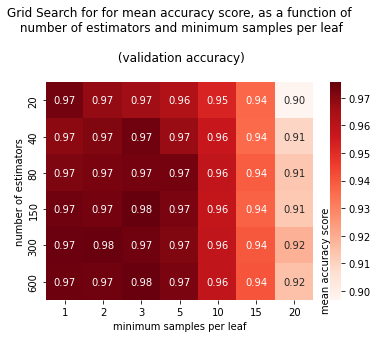

In [105]:
sns.heatmap( grid_search_results.pivot("param_RFR__n_estimators", "param_RFR__min_samples_leaf", "mean_test_score"), cmap="Reds", annot=True, fmt=".2f" )
plt.title("Grid Search for for mean accuracy score, as a function of\n number of estimators and minimum samples per leaf\n\n (validation accuracy)\n")
plt.xlabel("minimum samples per leaf")
plt.ylabel("number of estimators")
plt.text(7.2,6.3,"mean accuracy score", rotation = 'vertical')
plt.show()

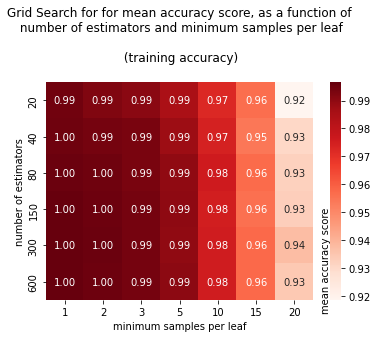

In [106]:
sns.heatmap( grid_search_results.pivot("param_RFR__n_estimators", "param_RFR__min_samples_leaf", "mean_train_score"), cmap="Reds", annot=True, fmt=".2f" )
plt.title("Grid Search for for mean accuracy score, as a function of\n number of estimators and minimum samples per leaf\n\n (training accuracy)\n")
plt.xlabel("minimum samples per leaf")
plt.ylabel("number of estimators")
plt.text(7.2,6.3,"mean accuracy score", rotation = 'vertical')
plt.show()

**Question 24:**

In [107]:
optimal_n = grid_search.best_params_['RFR__n_estimators']
optimal_leaf = grid_search.best_params_['RFR__min_samples_leaf']
best_RF = Pipeline([( 'feature_mapping', ColumnTransformer( ColumnTransformer_list_improved, remainder='passthrough' )),
                      ('RFR', RandomForestRegressor(n_estimators = optimal_n, min_samples_leaf = optimal_leaf)  ) ] )
cv_results = cross_validate(best_RF, X_all_train_cpy, y_all_train_cpy, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
print("New obtained train score:", cv_results['train_score'].mean())
print("New obtained test score:", cv_results['test_score'].mean())

New obtained train score: -0.6369950493390323
New obtained test score: -2.7156771794819248


**Task:** Train the RF regressor on the entire training set and save it for future use.

In [108]:
X_all_train_cpy = train_normalized.drop('contamination_level', inplace=False, axis=1).copy()
y_all_train_cpy = np.array(train_normalized["contamination_level"]).copy()

best_RF.fit(X_all_train_cpy, y_all_train_cpy)

Pipeline(steps=[('feature_mapping',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('RBF',
                                                  RBFSampler(gamma=100.0,
                                                             random_state=157),
                                                  ['num_of_siblings']),
                                                 ('Poly_5',
                                                  PolynomialFeatures(degree=5),
                                                  ['weight', 'PCR_02'])])),
                ('RFR',
                 RandomForestRegressor(min_samples_leaf=3, n_estimators=150))])

# **Section 6: Testing your models**

**Question 25:**

In [109]:
from sklearn.metrics import mean_squared_error

In [110]:
X_all_test_cpy = test_normalized.drop('contamination_level', inplace=False, axis=1).copy()
y_all_test_cpy = np.array(test_normalized["contamination_level"]).copy()

best_model_dict = {"Dummy": best_dummy,"Linear Regressor": best_LinearReg, "Lasso Regressor": best_LassoReg, "Random Forest": best_RF}
for model_name in best_model_dict:
  print( model_name, "test score:", mean_squared_error( best_model_dict[model_name].predict(X_all_test_cpy), y_all_test_cpy ) )

Dummy test score: 103.36031368589326
Linear Regressor test score: 96.39213495446941
Lasso Regressor test score: 94.83809219244897
Random Forest test score: 1.4313263886024012


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
